## Pitch Names Classifier

In [1]:
import numpy as np

from htm.bindings.sdr import SDR
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.algorithms import SpatialPooler as SP
from htm.algorithms import TemporalMemory as TM
from htm.bindings.algorithms import Classifier

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

In [2]:
pitchNames = ("C","D","E","F","G","A","B")

scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 0
scalarEncoderParams.maximum = 6
scalarEncoderParams.activeBits = 3
scalarEncoderParams.category = True

enc = ScalarEncoder(scalarEncoderParams)

print ("C: ", enc.encode(0))
print ("D: ", enc.encode(1))
print ("E: ", enc.encode(2))
print ("F: ", enc.encode(3))
print ("G: ", enc.encode(4))
print ("A: ", enc.encode(5))
print ("B: ", enc.encode(6))

C:  SDR( 21 ) 0, 1, 2
D:  SDR( 21 ) 3, 4, 5
E:  SDR( 21 ) 6, 7, 8
F:  SDR( 21 ) 9, 10, 11
G:  SDR( 21 ) 12, 13, 14
A:  SDR( 21 ) 15, 16, 17
B:  SDR( 21 ) 18, 19, 20


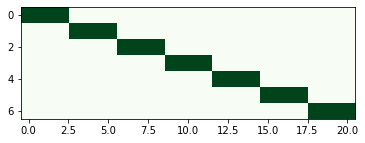

In [3]:
n_samples = int(enc.parameters.maximum - enc.parameters.minimum + 1)

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
  sdrs.append( enc.encode( i ).dense )

plt.imshow(np.array(sdrs), cmap = "Greens")
plt.show()

In [4]:
inputSDR  = SDR( dimensions = (21, ) )
activeSDR = SDR( dimensions = (576,) )
sp = SP(inputDimensions  = inputSDR.dimensions,
        columnDimensions = activeSDR.dimensions,
        localAreaDensity = 0.02,
        globalInhibition = True,
        seed             = 1,
        synPermActiveInc   = 0.01,
        synPermInactiveDec = 0.008)

print(sp)

Spatial Pooler Connections:
    Inputs (21) ~> Outputs (576) via Segments (576)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 11 / 11 / 11
    Connected Synapses on Segment Min/Mean/Max 1 / 5.44097 / 10
    Synapses Dead (0%) Saturated (0%)
    Synapses pruned (0%) Segments pruned (0%)



In [5]:
clsr = Classifier()

In [6]:
tm = TM(
    columnDimensions = (576,),
    cellsPerColumn=11,
    initialPermanence=0.5,
    connectedPermanence=0.5,
    minThreshold=8,
    maxNewSynapseCount=20,
    permanenceIncrement=0.1,
    permanenceDecrement=0.0,
    activationThreshold=8,
)
print(tm)

Temporal Memory Connections:
    Inputs (0) ~> Outputs (6336) via Segments (0)
    Segments on Cell Min/Mean/Max 0 / 0 / 0
    Potential Synapses on Segment Min/Mean/Max 4294967295 / nan / 0
    Connected Synapses on Segment Min/Mean/Max 65535 / nan / 0
    Synapses Dead (nan%) Saturated (nan%)
    Synapses pruned (nan%) Segments pruned (nan%)



In [7]:
batch=10
for n in range(batch):    
    for i in range(len(pitchNames)):
        inputSDR = enc.encode(i)
        print("input SDR: ",inputSDR)
        sp.compute(inputSDR, True, activeSDR)
        print("Active SDR: ",activeSDR)
        clsr.learn( activeSDR, i )
        print("Classifier learn: ",i)
        print("")

        #clear_output(wait = True)
        #plt.cla
        #sampleSDR=activeSDR.dense.reshape(24,24)
        #plt.imshow(sampleSDR, cmap = "Blues")
        #plt.pause(0.01)

        tm.compute( activeSDR, learn=True)
        tm.activateDendrites(True)
        print(tm.getPredictiveCells())
        print("")
print(tm)

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0

SDR( 576, 11 )

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1

SDR( 576, 11 )

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 542, 545, 546, 547, 558, 571, 573
Classifier learn:  2

SDR( 576, 11 )

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3

SDR( 576, 11 )

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4

SDR( 576, 11 )

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5

SDR( 576, 11 )

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier lear

In [11]:
for i in range(len(pitchNames)):
    print("--- ", i ," ---")
    inputSDR = enc.encode(i)
    print("input SDR: ",inputSDR)
    sp.compute(inputSDR, False, activeSDR)
    print("Active SDR: ",activeSDR)
    print("")

    #sampleSDR=activeSDR.dense.reshape(24,24)
    #plt.imshow(sampleSDR, cmap = "Blues")
    #plt.pause(0.01)

    tm.reset()
    tm.compute( activeSDR, learn=False)
    tm.activateDendrites(True)
    activeColumnsIndices   = [tm.columnForCell(i) for i in tm.getActiveCells().sparse]
    predictedColumnIndices = [tm.columnForCell(i) for i in tm.getPredictiveCells().sparse]

    print(tm.getActiveCells())
    print(tm.getPredictiveCells())

    active_sdr = SDR( tm.numberOfColumns() )
    active_sdr.sparse  = np.array(sorted(set(activeColumnsIndices)))
    print("-"*70 )
    print("Active sdr: ", active_sdr)

    predict_sdr = SDR( tm.numberOfColumns() )
    predict_sdr.sparse  = np.array(sorted(set(predictedColumnIndices)))
    print("-"*70 )
    print("Predicted sdr: ",predict_sdr)

    if  len(predict_sdr.sparse) == 0:
        tm_predict = "nan"
        tm_pitchNames = "nan"      
    else:
        tm_predict = np.argmax( clsr.infer( predict_sdr) ) 
        tm_pitchNames = pitchNames[tm_predict]

    print("-"*70 )
    print("PDF: ",clsr.infer( predict_sdr) )
    print("-"*70 )

    print("predict index: ",tm_predict)
    print("-"*70 )
    print("predict label: ",tm_pitchNames)

    print("")

    #sampleSDR=predict_sdr.dense.reshape(24,24)
    #plt.imshow(sampleSDR, cmap = "Reds")
    #plt.pause(0.01)

---  0  ---
input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572

SDR( 576, 11 ) 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302
SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325
----------------------------------------------------------------------
